# Object Detection


This example performs Object Detection. 
SSD-based object detection model trained on Open Images V4 with ImageNet pre-trained MobileNet V2 as image feature extractor.
(By google)

We can visualize these bounding boxes on top of the image

## Setup


In [1]:
# For running inference on the TF-Hub module.
import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.8.0
The following GPU devices are available: /device:GPU:0


### Select and load the model

* [ssd + mobilenet V2](https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2) is small and fast.

In [2]:

# ssd mobilenet version 2
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"


#### Load the model

Load the model specified by the `module_handle`.
- This will take a few minutes to load the model.

In [3]:
model = hub.load(module_handle)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


#### Choose the default signature

Check the available signatures using `.signature.keys()`

In [4]:
# take a look at the available signatures for this particular model
model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction pruned(images) at 0x7FF3750561D0>}))

We should choose the 'default' signature for the object detector.

In [5]:
detector = model.signatures['default']

### download_and_resize_image

This function downloads an image specified by a given "url", pre-processes it, and then saves it to disk.
- What new compared to the previous lab is that you an display the image if you set the parameter `display=True`.

In [6]:
def display_image(image):
    """
    Displays an image inside the notebook.
    This is used by download_and_resize_image()
    """
    fig = plt.figure(figsize=(10, 7))
    plt.axis(False)
    plt.grid(False)
    plt.imshow(image)


def download_and_resize_image(link_topic, new_width=256, new_height=256, display=False):
    '''
    Fetches an image, resizes it and saves it locally.
    
    Args:
        url (string) -- link to the image
        new_width (int) -- size in pixels used for resizing the width of the image
        new_height (int) -- size in pixels used for resizing the length of the image
        
    Returns:
        (string) -- path to the saved image
    '''
    
    # create a temporary file ending with ".jpg"
    _, filename = tempfile.mkstemp(suffix=".jpg")
    
    # opens the image

    pil_image = Image.open(link_topic)
    
    # resizes the image. will crop if aspect ratio is different.
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    
    # converts to the RGB colorspace
    pil_image_rgb = pil_image.convert("RGB")
    
    # saves the image to the temporary file created earlier
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    
    print("Image to %s." % filename)
    
    if display:
        display_image(pil_image)

    
    return filename

### Draw bounding boxes

You can now visualize the predicted bounding boxes, overlaid on top of the image.  
- You can use `draw_boxes` to do this.  It will use `draw_bounding_box_on_image` to draw the bounding boxes.

In [7]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):

    """
    Adds a bounding box to an image.
    
    Args:
        image -- the image object
        ymin -- bounding box coordinate
        xmin -- bounding box coordinate
        ymax -- bounding box coordinate
        xmax -- bounding box coordinate
        color -- color for the bounding box edges
        font -- font for class label
        thickness -- edge thickness of the bounding box
        display_str_list -- class labels for each object detected
    
    
    Returns:
        No return.  The function modifies the `image` argument 
                    that gets passed into this function
    
    """
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    
    # scale the bounding box coordinates to the height and width of the image
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    
    # define the four edges of the detection box
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
        
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.25):
    """
    Overlay labeled boxes on an image with formatted scores and label names.
    
    Args:
        image -- the image as a numpy array
        boxes -- list of detection boxes
        class_names -- list of classes for each detected object
        scores -- numbers showing the model's confidence in detecting that object
        max_boxes -- maximum detection boxes to overlay on the image (default is 10)
        min_score -- minimum score required to display a bounding box
    
    Returns:
        image -- the image after detection boxes and classes are overlaid on the original image.
    """
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        
        # only display detection boxes that have the minimum score or higher
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

            # draw one bounding box and overlay the class labels onto the image
            draw_bounding_box_on_image(image_pil,
                                       ymin,
                                       xmin,
                                       ymax,
                                       xmax,
                                       color,
                                       font,
                                       display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
        
    return image

### run_detector

This function will take in the object detection model `detector` and the path to a sample image, then use this model to detect objects.
- This time, run_dtector also calls `draw_boxes` to draw the predicted bounding boxes.

In [8]:
def load_img(path):
    '''
    Loads a JPEG image and converts it to a tensor.
    
    Args:
        path (string) -- path to a locally saved JPEG image
    
    Returns:
        (tensor) -- an image tensor
    '''
    
    # read the file
    img = tf.io.read_file(path)
    
    # convert to a tensor
    img = tf.image.decode_jpeg(img, channels=3)
    
    return img


def run_detector(detector, path):
    '''
    Runs inference on a local file using an object detection model.
    
    Args:
        detector (model) -- an object detection model loaded from TF Hub
        path (string) -- path to an image saved locally
    '''
    
    # load an image tensor from a local file path
    img = load_img(path)

    # add a batch dimension in front of the tensor
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    
    # run inference using the model
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    # save the results in a dictionary
    result = {key:value.numpy() for key,value in result.items()}
    
    # print results
    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    # draw predicted boxes over the image
    image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

    # display the image
    display_image(image_with_boxes)

### Run the detector on more images
Perform inference on some images

In [19]:
image_list = [
  "gdrive/My Drive/Colab Notebooks/IMG_1626.JPG",
  "gdrive/My Drive/Colab Notebooks/IMG_1620.JPG",
  "gdrive/My Drive/Colab Notebooks/IMG_1019.JPG"
  ]

def detect_img(image):
    start_time = time.time()
    image_path = download_and_resize_image(image, 640, 480)
    run_detector(detector, image_path)
    end_time = time.time()
    print("Inference time:",end_time-start_time)

In [15]:
from google.colab import drive
drive.mount('gdrive')


Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


Image to /tmp/tmp7pcb3qgc.jpg.
Found 100 objects.
Inference time:  0.9391627311706543
Inference time: 1.5428881645202637


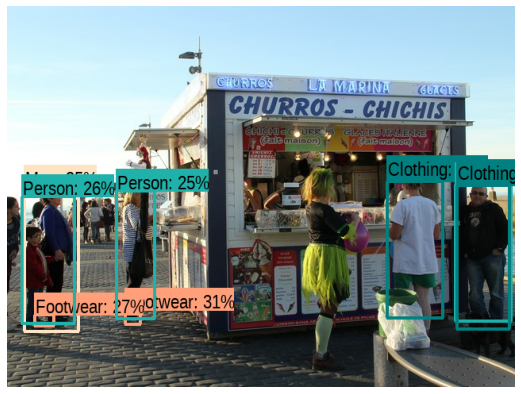

In [20]:
detect_img(image_list[0])

Image to /tmp/tmpk4in9j5w.jpg.
Found 100 objects.
Inference time:  0.9622995853424072
Inference time: 1.544309139251709


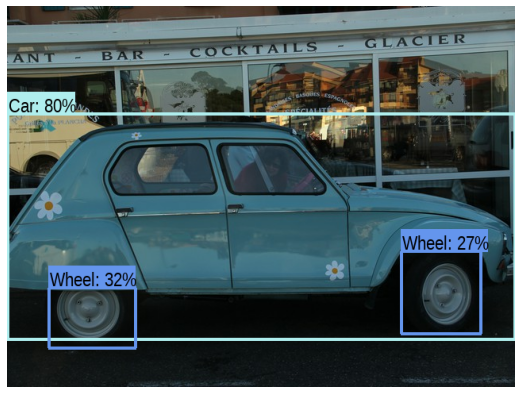

In [21]:
detect_img(image_list[1])

Image to /tmp/tmp61hvh9n8.jpg.
Found 100 objects.
Inference time:  0.958296537399292
Inference time: 1.0527012348175049


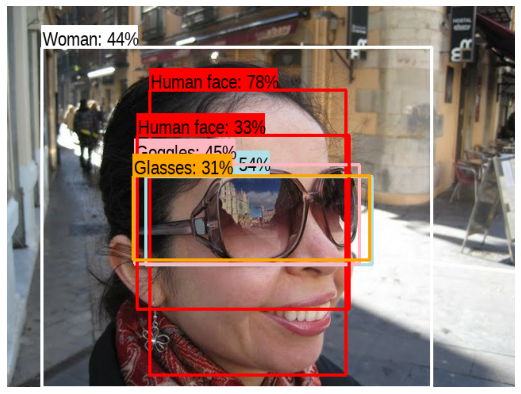

In [22]:
detect_img(image_list[2])